In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import zipfile
with zipfile.ZipFile('/content/drive/My Drive/all/ASL/asl-alphabet-test.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/asl_test')     #extract data

In [0]:
import os 
i=os.listdir('/content/drive/My Drive/all/ASL/asl_alphabet_train/A')
len(i)                        #number of imgages per class

3000

In [0]:
import shutil
shutil.move('/content/asl_test/Y/asl-alphabet-test','/content/kk')

'/content/kk/asl-alphabet-test'

In [0]:

try :
 %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

In [0]:
#get the imports necessary
from __future__ import print_function, division
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch.utils import data
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset , DataLoader
from torchvision import datasets, transforms, models,utils
from PIL import Image
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('/content/drive/My Drive/all/ASL_MODELS/ASL_ENB2/graphs_2')
import os
import pandas as pd
from skimage import io, transform
import numpy as np
import shutil
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [0]:
#Custom data generator in case you want to use sign eminist dataset to train the model or else it is nt required
class Dataset(data.Dataset):

  def __init__(self, df, transform = None):
     
        self.landmarks_frame = df
        
        self.transform= transform
  def __len__(self):
        'Denotes the total number of samples'
        return len(self.landmarks_frame)

  def __getitem__(self, idx):
      
    
        if torch.is_tensor(idx):
            idx = idx.tolist()
      
        val=self.landmarks_frame.iloc[idx,1:].values
        
        img = Image.fromarray(np.uint8(val) , 'L')
        print(val.shape)
        
        if self.transform:

          X = self.transform(img)
          
        print(X.shape)
        label_n = self.landmarks_frame.iloc[idx,0]
      

        return X,label_n

In [0]:

#use this snippet if you are tru=ying Sign mnist dataset
try_transform = transforms.Compose([transforms.Resize((260,260)),
                                transforms.ToTensor()])

train_dataset =  Dataset(train_df, try_transform)
test_dataset =  Dataset(val_df,try_transform)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True,num_workers=60)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=64,num_workers=60)

In [0]:
#for normal ASL data use this snippet
try_transform = transforms.Compose([transforms.Resize((260,260)),
                                transforms.ToTensor()])
train_data = datasets.ImageFolder('/content/kk',  
                                    transform=try_transform) 
test_data = datasets.ImageFolder('/content/asl_test',  
                                     transform=try_transform) 
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True,num_workers=50)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64,num_workers=50)

In [0]:
model = torch.hub.load('rwightman/gen-efficientnet-pytorch', 'efficientnet_b2', pretrained=True)

Using cache found in /root/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


In [0]:
## freezing model 
for param in model.parameters():
    param.requires_grad = False
    
    
# change last layer of model
model.classifier = nn.Sequential(nn.Linear(1408, 704),
                         nn.ReLU(),
                         nn.Dropout(0.2),
                         nn.Linear(704, 128),
                         nn.ReLU(),
                      
                         nn.Linear(128, 29)
                        )

In [0]:
model      #view model architechture

In [0]:
def save_ckp(state, is_best, checkpoint_path, best_model_path):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """
    f_path = checkpoint_path
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, f_path)
    # if it is a best model, min validation loss
    if is_best:
        best_fpath = best_model_path
        # copy that checkpoint file to best path given, best_model_path
        shutil.copyfile(f_path, best_fpath)


In [0]:
def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    #valid_loss_min = checkpoint['valid_loss_min']
    # return model, optimizer, epoch value, min validation loss 
    print(checkpoint['epoch'])
    return model, optimizer,checkpoint['epoch']


In [0]:
def compute_accuracy(true_labels, predictions):
    return (true_labels == torch.argmax(predictions,axis=1)).type(torch.FloatTensor).mean()

In [0]:
## model training
def train_one_epoch(model, criterion, optimizer, train_loader, device):
    
    epoch_loss = 0
    acc = 0
    # put model in train mode
    model.train()
    print("training...n")
    for train_x, train_y in train_loader:
        # move data to device
        train_x = train_x.to(device)
        train_y = train_y.to(device)
        
        print(train_x.shape)
        optimizer.zero_grad()
        u_logits = model(train_x)
        current_loss = criterion(u_logits, train_y)
        epoch_loss += current_loss.item()
        #print(len(train_y.cpu()))
        acc += compute_accuracy(train_y.cpu(), F.softmax(u_logits.cpu(),dim=1))
        current_loss.backward()
        optimizer.step()
        
    return epoch_loss/ len(train_loader), acc/ len(train_loader)

In [0]:
def eval_one_epoch(model, criterion, val_loader, device):
    epoch_loss = 0
    acc = 0
    # put model in eval mode
    model.eval()
    preds,actual=list(),list()
    with torch.no_grad():
        for val_x, val_y in val_loader:
            # move data to device
            val_x = val_x.to(device)
            val_y = val_y.to(device)
            u_logits = model(val_x)
            current_loss = criterion(u_logits, val_y)
            epoch_loss += current_loss.item()
            for i in torch.argmax(F.softmax(u_logits.cpu(),dim=1),axis=1):
              preds.append(i)
            for i in val_y.cpu():
              actual.append(i)
            acc += compute_accuracy(val_y.cpu(), F.softmax(u_logits.cpu(),dim=1))
    print(metrics.classification_report(actual,preds))
    return epoch_loss/ len(val_loader), acc/ len(val_loader)

In [0]:
def train(model, train_loader, val_loader, num_epochs, device, print_every=5):
    model = model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    LR = 1e-3
    # adam_optim = optim.Adam(model.classifier.parameters(), lr= LR)   #if you are using this code for the first time then uncomment this line and comment next two line and if you want to continue training form checkpoint then comment this line and use the next two
    checkpoint_fpath ='/content/drive/My Drive/all/ASL_MODELS/ASL_ENB2/checkpt_from_asl_1.pt'
    model,adam_optim,epoch=load_ckp(checkpoint_fpath, model, optim.Adam(model.classifier.parameters(), lr= LR))
   
    scheduler = torch.optim.lr_scheduler.StepLR(adam_optim, step_size=25, gamma=0.5)
    train_loss_hist = []
    val_loss_hist = []
    train_acc_hist = []
    val_acc_hist = []
    valid_loss_min = 6
    for epoch_index in range(num_epochs+1):
        train_loss, train_acc = train_one_epoch(model, criterion, adam_optim, train_loader, device)                                        
        # add train loss and acc to hist
        train_loss_hist.append(train_loss)
        train_acc_hist.append(train_acc)
        writer.add_scalar('train/loss',train_loss,epoch_index)
        writer.add_scalar('train/acc',train_acc,epoch_index)
        checkpoint = {
            'epoch': epoch_index + 1,
            'loss': train_loss,
            'acc':train_acc,
            'state_dict': model.state_dict(),
            'optimizer': adam_optim.state_dict(),
              }
        
        print(f"epoch: {epoch_index}, train loss:{train_loss}, train_acc: {train_acc}")  
        
        save_ckp(checkpoint, False, '/content/drive/My Drive/all/ASL_MODELS/ASL_ENB2/checkpt.pt', '/content/drive/My Drive/all/ASL_MODELS/ASL_ENB2/best_mod.pt')
        
        if ((epoch_index % print_every) == 0):
            val_loss, val_acc = eval_one_epoch(model, criterion, val_loader, device)
            print(f"epoch: {epoch_index}, val_loss: {val_loss}, val_acc: {val_acc}")                                        
            # add val loss and acc to hist
            val_loss_hist.append(val_loss)
            val_acc_hist.append(val_acc)
            writer.add_scalar('val/loss',val_loss,epoch_index)
            writer.add_scalar('val/acc',val_acc,epoch_index)
            checkpoint = {
            'epoch': epoch_index + 1,
            'valid_loss_min': val_loss,
            'state_dict': model.state_dict(),
            'optimizer': adam_optim.state_dict(),
              }

            if val_loss <= valid_loss_min:
              print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,val_loss))
              # save checkpoint as best model
              save_ckp(checkpoint, True, '/content/drive/My Drive/all/ASL_MODELS/ASL_ENB2/checkpt.pt', '/content/drive/My Drive/all/ASL_MODELS/ASL_ENB2/best_mod/best_mod.pt')
              valid_loss_min = val_loss
            #### model saving code here 
        scheduler.step()              
    return train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("training started on {}".format(device))
NUM_EPOCHS = 60
train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist = train(model, trainloader, testloader, NUM_EPOCHS, device)

In [0]:
from PIL import Image
import numpy as np

In [0]:
image = Image.open('/content/drive/My Drive/all/ASL/asl_alphabet_test/A/A_test.jpg')

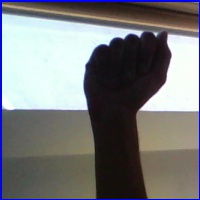

In [0]:
display(image)